In [1]:
import os
import random

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from numpy import linalg as la

from ipywidgets import IntProgress
from IPython.display import display

sns.set()

# Utilities

In [2]:
class InfoArray(np.ndarray):

    def __new__(cls, input_array, info=None):
        obj = np.asarray(input_array).view(cls)
        obj.info = info
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.info = getattr(obj, 'info', None)

def img_show(img, title = '', figsize=(20,10)):
    plt.figure(figsize=figsize)
    sns.set_style("white")
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    
def imgs_show(imgs, rows, fontsize=36):
    fig = plt.figure()
    sns.set_style("white")
    for n, (img, title) in enumerate(imgs):
        a = fig.add_subplot(rows, np.ceil(len(imgs)/float(rows)), n + 1)
        a.set_title(title, fontdict={"fontsize": fontsize})
        plt.gray()
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
    plt.show()
    
def read_folder(folder, ext):
    images = []

    for r, d, f in os.walk(folder):
        for file in f:
            if file.endswith(ext):
                path = os.path.join(r, file)
                images.append(InfoArray(cv2.imread(path, cv2.IMREAD_GRAYSCALE), info=path))

    return images

# Download datasets

In [3]:
%%bash

FACES_LINK="http://mlsp.cs.cmu.edu/courses/fall2013/assignments/assignment2/lfw1000.zip"
FACES_FILE_NAME="lfw1000.zip"

NON_FACES_FILE_NAME="non_face.zip"

download() {
    if [ -f "$2" ]; then
        echo "$2 exist"
    else 
        curl "$1" --output "$2"
    fi
}

download $FACES_LINK $FACES_FILE_NAME

unzip $FACES_FILE_NAME
unzip att_faces.zip -d att_faces
unzip $NON_FACES_FILE_NAME

# Read datasets LFW1000 and Linnaeus 5 64X64

In [4]:
images = np.array(read_folder('./lfw1000/', '.pgm'))
non_face_images = np.array(read_folder('./non_face/', '.jpg'))

print("Faces dataset: {}. Non-faces dataset: {}".format(images.shape, non_face_images.shape))

train, test = train_test_split(images, test_size=.2, random_state=512, shuffle=True)
print("Train set shape: {}. Test set shape: {}".format(train.shape, test.shape))

_, non_face_test = train_test_split(non_face_images, test_size=.1, random_state=512)
print("Non face test set shape: {}".format(non_face_test.shape))

Faces dataset: (1071, 64, 64). Non-faces dataset: (2000, 64, 64)
Train set shape: (856, 64, 64). Test set shape: (215, 64, 64)
Non face test set shape: (200, 64, 64)


# Data exploration of FW1000 and Linnaeus 5 64X64 datasets

Lets check sample from the dataset with faces and see the mean face. And also check non faces data.

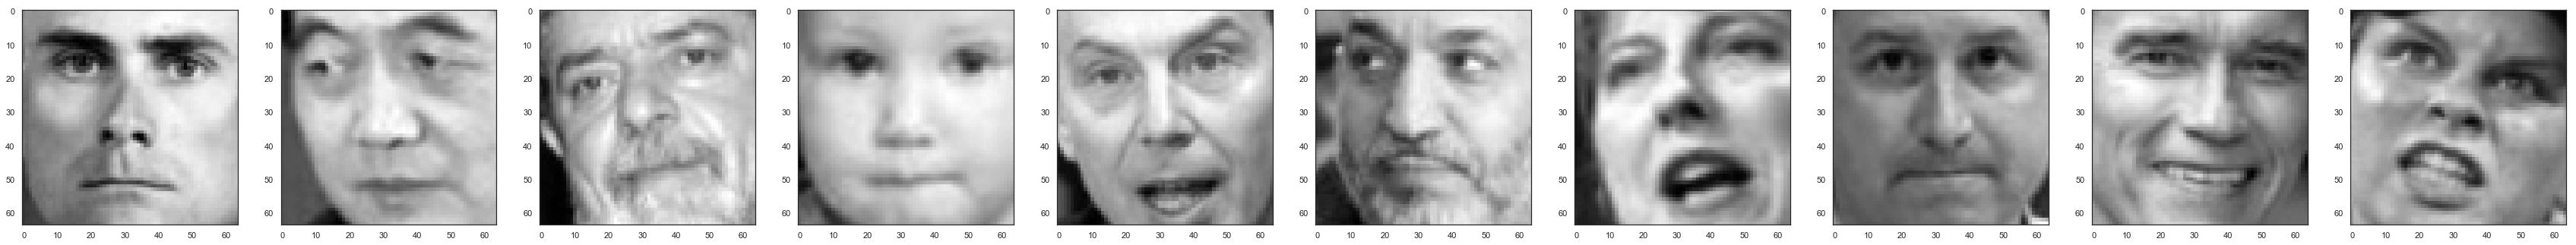

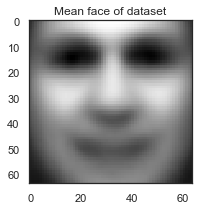

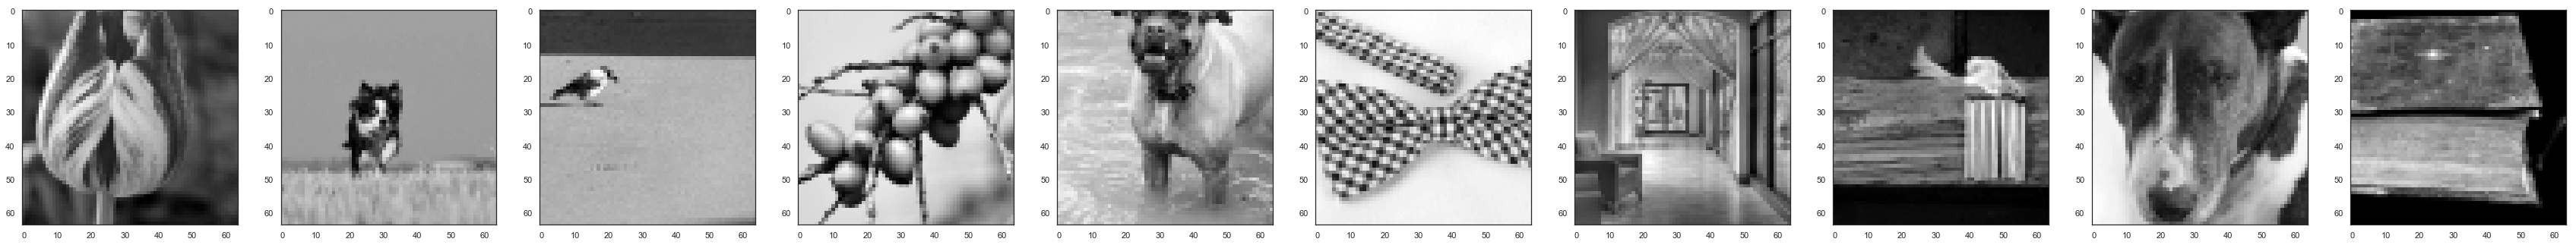

In [5]:
random.seed(512)

sample = [(images[i], "") for i in random.sample(range(0, len(images)), 10)]
imgs_show(sample, 1)
img_show(np.mean(images, axis=(0)), title="Mean face of dataset", figsize=(4,3))

imgs_show([(non_face_images[i], "") for i in random.sample(range(0, len(non_face_images)), 10)], 1)

# PCA classifier implementation

In [6]:
class Classifier:
    def __init__(self):
        self.data = None
        self.mean = 0
        self.normalized = None
        self.cov = None
        
        self.desc_ordered_vals_indexes = None
        self.eigenvals = None
        self.eigenvecs = None
        self.eigenfaces = None
        
        self.number_of_components = 0
        self.weights = None
        
        self.threshold = 0
        
    def fit(self, X):
        self.data = X
        self.mean = np.mean(X, axis=0)
        self.normalized = np.array([(x - self.mean).flatten() for x in self.data])
        self.cov = self.normalized.dot(self.normalized.T)/self.normalized.shape[0]
        
        vals, vecs = la.eig(self.cov)
        self.desc_ordered_vals_indexes = np.flip(np.argsort(vals))
        
        self.eigenvals = np.array([vals[i] for i in self.desc_ordered_vals_indexes])
        self.eigenvecs = np.array([vecs[i] for i in self.desc_ordered_vals_indexes])
        
        eigenfaces = self.normalized[self.desc_ordered_vals_indexes].T.dot(self.eigenvecs)
        self.eigenfaces = eigenfaces/la.norm(eigenfaces, axis=0)
    
    def calculate_weights(self, number_of_components):
        eigenfaces_to_use = self.eigenfaces[:,:number_of_components]
        training_data = np.array([(x - self.mean).flatten() for x in self.data])
        
        self.weights = np.dot(training_data, eigenfaces_to_use)
        self.number_of_components = number_of_components
        
    def calculate_threshold(self):
        distances = np.array([])
        for i in range(self.number_of_components):
            for j in range(i, self.number_of_components):
                distances = np.append(distances, np.sqrt(la.norm(self.weights[i] - self.weights[j])))
                
        self.threshold = np.max(distances) / 2
        return self.threshold
    
    def reduce_dimention(self, Y, number_of_components):
        y_normalized = (Y - self.mean).flatten()[..., np.newaxis]
        eigenfaces_to_use = self.eigenfaces[:, :number_of_components]
        return eigenfaces_to_use.dot(eigenfaces_to_use.T).dot(y_normalized) + self.mean.flatten()[..., np.newaxis]
    
    def __find_weights(self, Y):
        y_normalized = (Y - self.mean).flatten()[..., np.newaxis]
        eigenfaces_to_use = self.eigenfaces[:,:self.number_of_components]
        return np.dot(eigenfaces_to_use.T, y_normalized)
    
    def find_closest(self, Y):
        w_unknown = self.__find_weights(Y)
        eps_k = np.sqrt(la.norm(np.subtract(self.weights, w_unknown.T), axis=1))
        min_eps_k = round(np.min(eps_k), 1)
        epsilon = round(self.calculate_epsilon(Y), 1)
        closest_img = self.data[np.argmin(eps_k)]
        
        threshold = round(self.threshold, 1)
#         print("Threshold:{}, Epsilon:{}, Epsilon_k:{}".format(threshold, epsilon, min_eps_k))
        
        if epsilon >= threshold:
            return closest_img, None
        elif epsilon < self.threshold and min_eps_k >= threshold:
            return closest_img, False
        return closest_img, True
        
    
    def calculate_epsilon(self, Y):
        w_unknown = self.__find_weights(Y)
        eigenfaces_to_use = self.eigenfaces[:,:self.number_of_components]
        reconstructed = eigenfaces_to_use.dot(w_unknown).reshape(Y.shape) + self.mean
        epsilon = np.sqrt(la.norm(Y.reshape(-1) - reconstructed.reshape(-1)))
        return epsilon
        
    def predict(self, Y):
        epsilon = self.calculate_epsilon(Y)
        return epsilon < self.threshold

# Add plots to PCA classifier

In [7]:
class PlotableClassifier(Classifier):
    def __init__(super):
        pass
    
    def plot_importance(self, n=10):
        first_n_eigenvalues = self.eigenvals[:n]
        importance = first_n_eigenvalues/np.sum(self.eigenvals)
        
        
        fig, ax = plt.subplots(figsize=(10, 8))
        df = pd.DataFrame({
            'Percentage of variances': importance, 
            'Principal components number': [i+1 for i in range(n)],
        })
        
        sns.set_style("whitegrid")
        sns.barplot(
            ax=ax,
            x='Principal components number', 
            y='Percentage of variances', 
            data=df,
            palette=sns.cubehelix_palette(8),
        ).set_title(
            'Amount of variances convered by {} principal components is {}%'.format(
                n, 
                round(df['Percentage of variances'].sum()*100, 3),
            ),
        )
        plt.show()
        
        return df
    
    def plot_dependence(self, thresholds=(0.95, 0.99)):
        sum_of_eigenvals = np.sum(self.eigenvals)
        first_threshold_reached = 0
        second_threshold_reached = 0
        dependence = [sum(self.eigenvals[:n+1])/sum_of_eigenvals for n in range(len(self.eigenvals))]
        for i, n in enumerate(dependence):
            if n > thresholds[0] and first_threshold_reached == 0:
                first_threshold_reached = i
            elif n > thresholds[1] and second_threshold_reached == 0:
                second_threshold_reached = i
                break
        
        df = pd.DataFrame({
            'Sum of variances': dependence, 
            'Principal components number': [i+1 for i in range(len(self.eigenvals))],
        })
        fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.lineplot(
            ax=ax,
            x='Principal components number', 
            y='Sum of variances', 
            data=df,
            palette=sns.color_palette("Blues_d", len(self.eigenvals)),
        ).set_title('Sum of variances. Thresholds={}. Number of components respectively={}'.format(
            thresholds, (first_threshold_reached, second_threshold_reached)
        ))
        
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        plt.axhline(y=thresholds[0], color='green')
        plt.axhline(y=thresholds[1], color='r')
        plt.axvline(first_threshold_reached, color='green')
        plt.axvline(second_threshold_reached, color='r')
        plt.show()
        
        return df
    
    def find_best_threshold(self, faces, non_faces, n=11):
        f = IntProgress(min=0, max=n, description='Computing:', bar_style='info')
        display(f)
        
        components = list(range(1,n+1))
        face_errors = np.array([])
        not_face_errors = np.array([])
        thresholds = np.array([])
 
        for k in components:
            pca.calculate_weights(k)
            thresholds = np.append(thresholds, pca.calculate_threshold())
            face_errors = np.append(face_errors, np.mean([pca.calculate_epsilon(face) for face in faces]))
            not_face_errors = np.append(not_face_errors, np.mean([pca.calculate_epsilon(image) for image in non_faces]))

            f.value += 1
            
        err_avg = np.array([(face_errors[i] + not_face_errors[i]) / 2 for i in range(n)])
        best = np.argmin(np.abs(err_avg - thresholds))
            
        df = pd.DataFrame({
            'Components': components,
            'Thresholds': thresholds,
            'Faces errors': face_errors, 
            'Non faces errors': not_face_errors,
            'Error avg': err_avg
        })
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.set_style("whitegrid")
        sns.lineplot(
            ax=ax, 
            x='Components', 
            y='value', 
            hue='variable', 
            data=pd.melt(df, ['Components']),
        ).set_title('Best number of components is: {}'.format(best+1))
        sns.regplot(x=np.array([best+1]), y=np.array([err_avg[best]]), scatter=True, fit_reg=False, marker='o', scatter_kws={"s": 100})
        return best+1
    
    def plot_eigenfaces_sample(self, n=10):
        random_eigenfaces_indexes = random.sample(range(0, self.eigenfaces.shape[1]), n)
        sample = [(self.eigenfaces.T[i].reshape(self.data[0].shape), "") for i in random_eigenfaces_indexes]
        imgs_show(sample, 1)

# Training the classifier on dataset

In [8]:
pca = PlotableClassifier()
pca.fit(train)

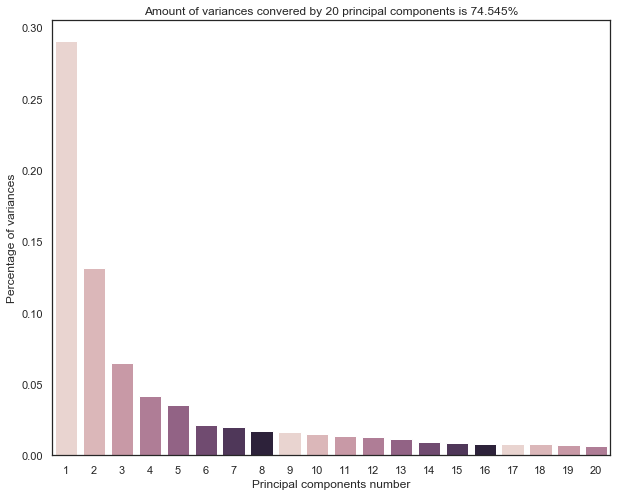

,Percentage of variances,Principal components number
0,0.290479,1
1,0.131222,2
2,0.064843,3
3,0.041324,4
4,0.035359,5


In [9]:
pca.plot_importance(n=20).head()

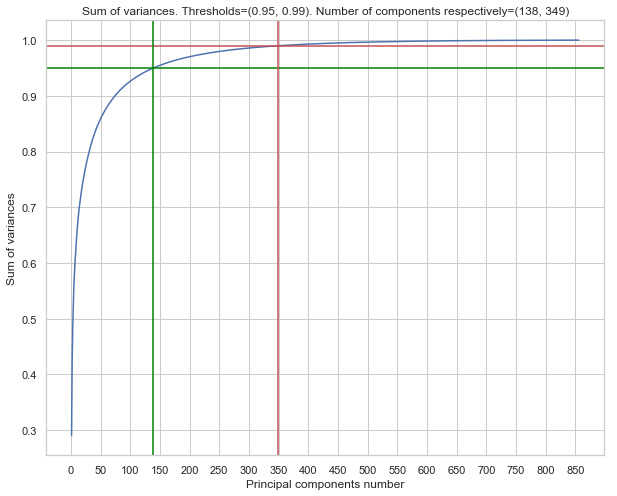

,Sum of variances,Principal components number
0,0.290479,1
1,0.421701,2
2,0.486544,3
3,0.527867,4
4,0.563227,5


In [10]:
pca.plot_dependence().head()

IntProgress(value=0, bar_style='info', description='Computing:', max=51)

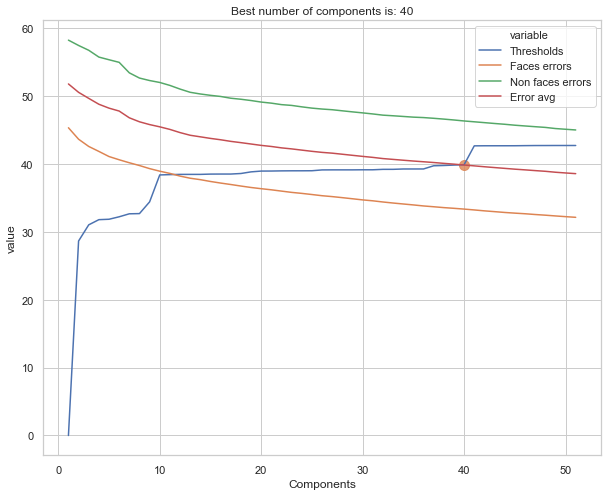

In [11]:
best_number_of_components = pca.find_best_threshold(test, non_face_test, n=51)

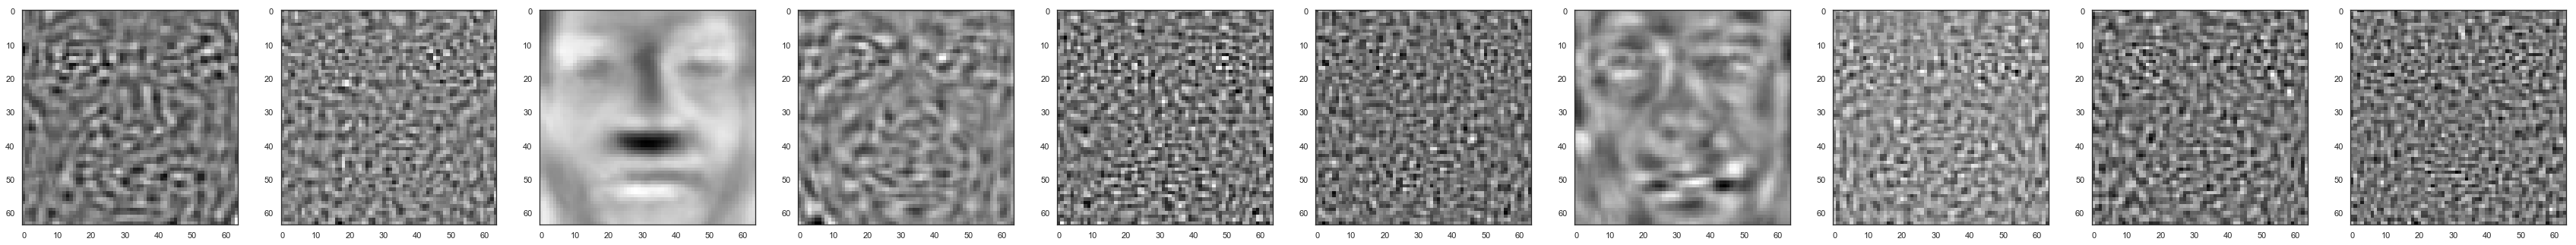

In [12]:
pca.plot_eigenfaces_sample()

# Reduce dimentionality of the image

One can notice that alogirthm performs well on faces in comparision with other type of objects.

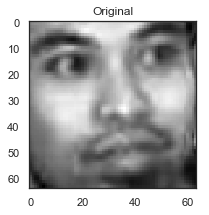

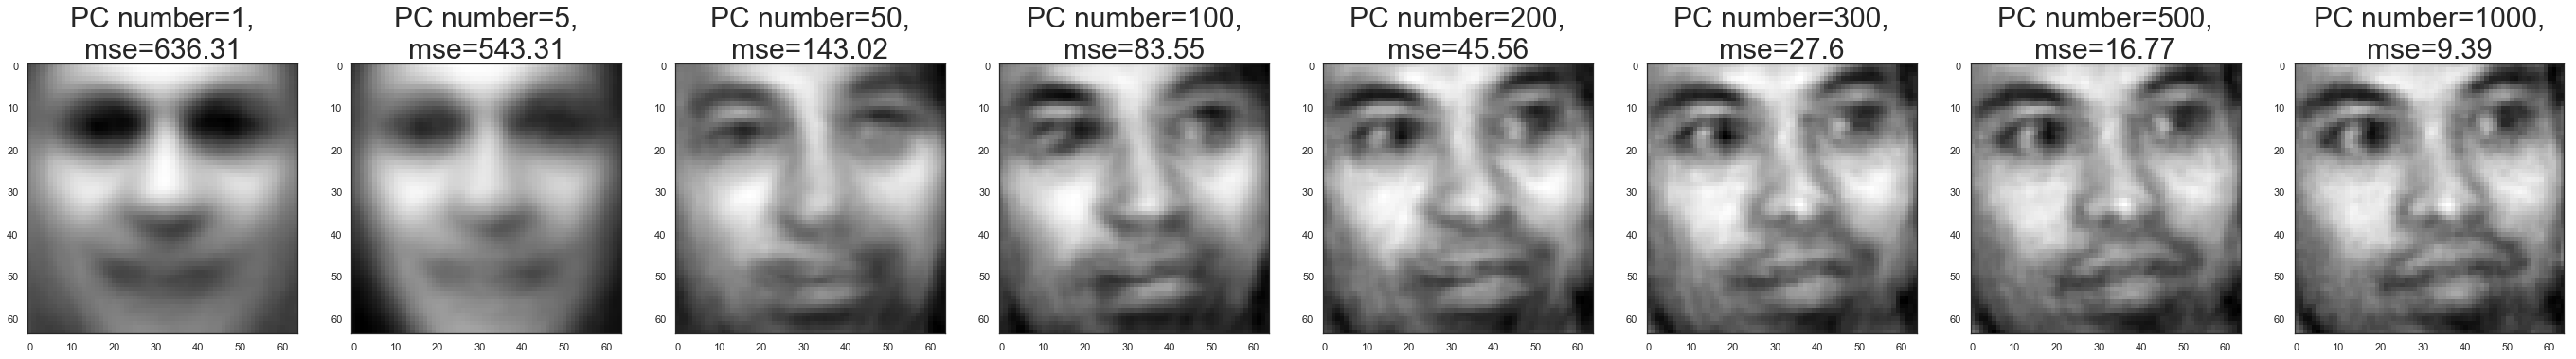

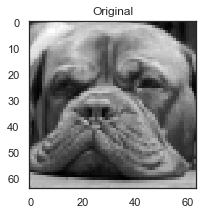

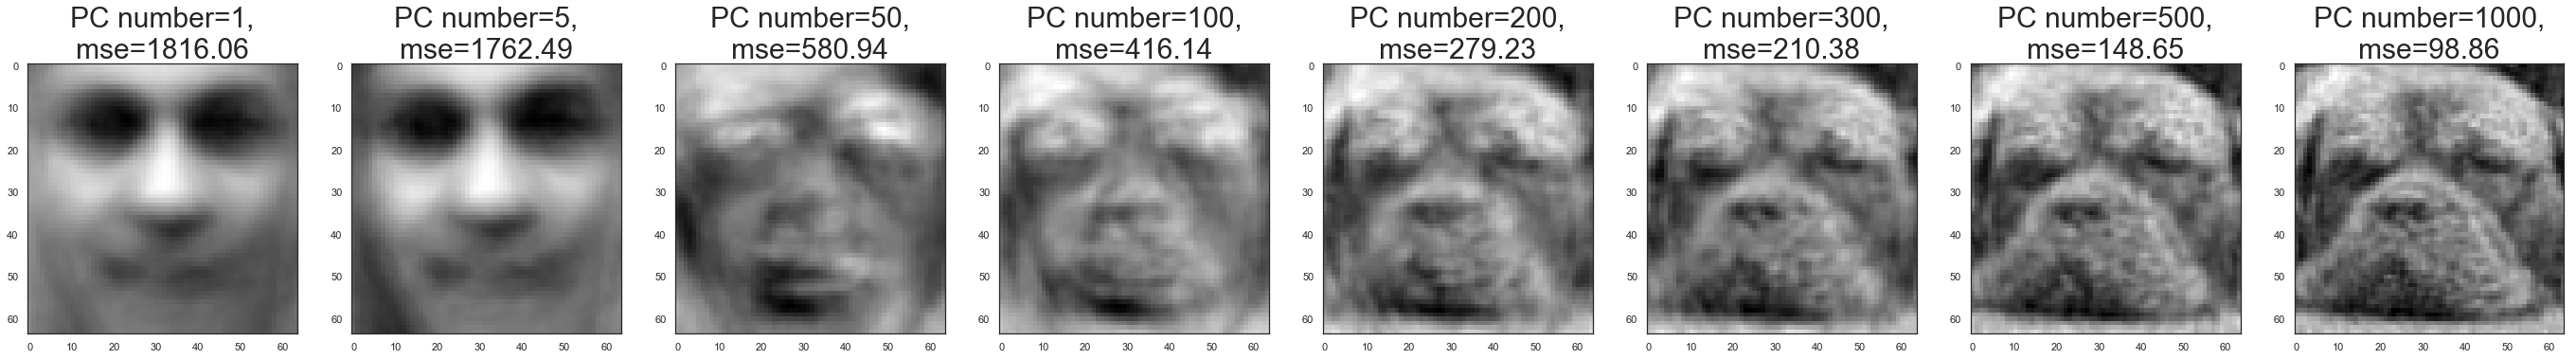

In [13]:
def dimentionality_reduction_plot(test_image, pca, prinicipal_components_number):
    img_show(test_image, "Original", figsize=(3,4))

    format_img_title = lambda i, img: "PC number={},\nmse={}".format(
        prinicipal_components_number[i], 
        round(np.square(test_image - img).mean(), 2),
    )

    reduced_dimentionality_images = [pca.reduce_dimention(test_image, i).reshape(test_image.shape) for i in prinicipal_components_number]
    images_to_plot = [(img, format_img_title(i, img)) for i, img in enumerate(reduced_dimentionality_images)]

    imgs_show(images_to_plot, 1, 30)
    
dimentionality_reduction_plot(test[0], pca, [1, 5, 50, 100, 200, 300, 500, 1000])
dimentionality_reduction_plot(non_face_images[0], pca, [1, 5, 50, 100, 200, 300, 500, 1000])

# Lets check how our solution will recognize the images in test datasets

Firstly we need to select number of prinicipal components for reconstraction, then calculate wights and project test data on the prinicipal components space.

In [14]:
pca.calculate_weights(best_number_of_components)
pca.calculate_threshold()

39.90671159858264

These faces hasn't been seen buy the alogorithm.

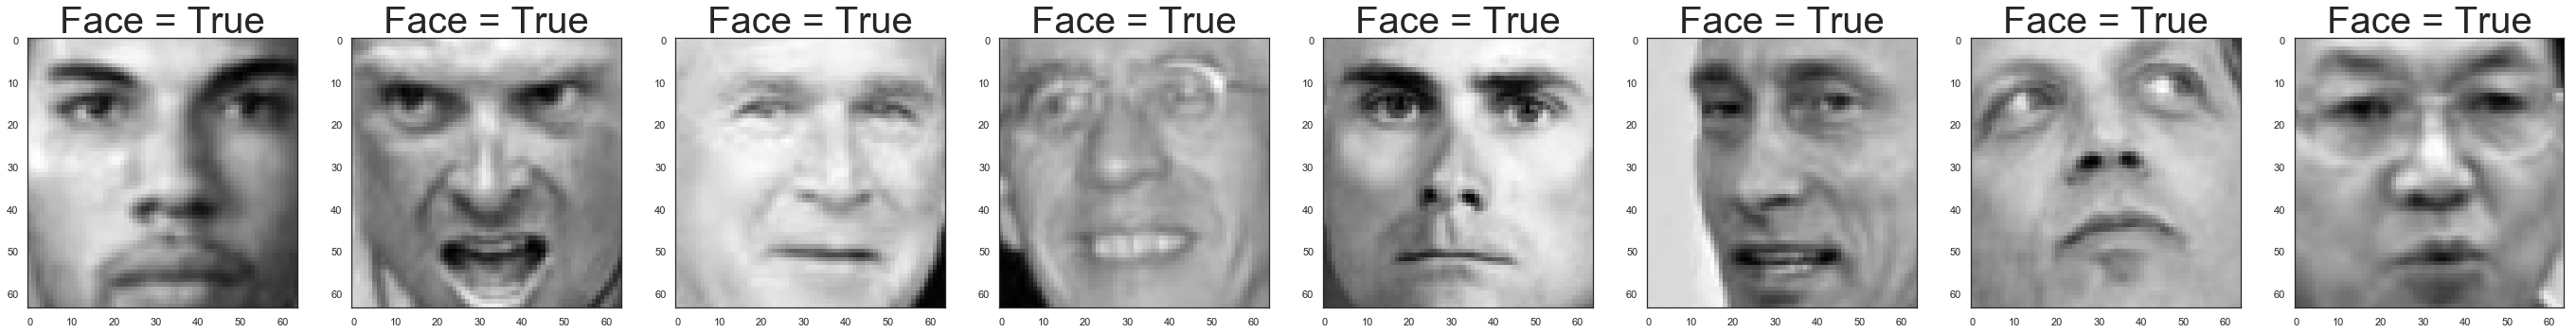

In [15]:
random.seed(512)
imgs_show([(test[i], "Face = {}".format(pca.predict(test[i]))) for i in random.sample(range(0, len(test)), 8)], 1, 40)

These images are not faces at all. Some of the images 

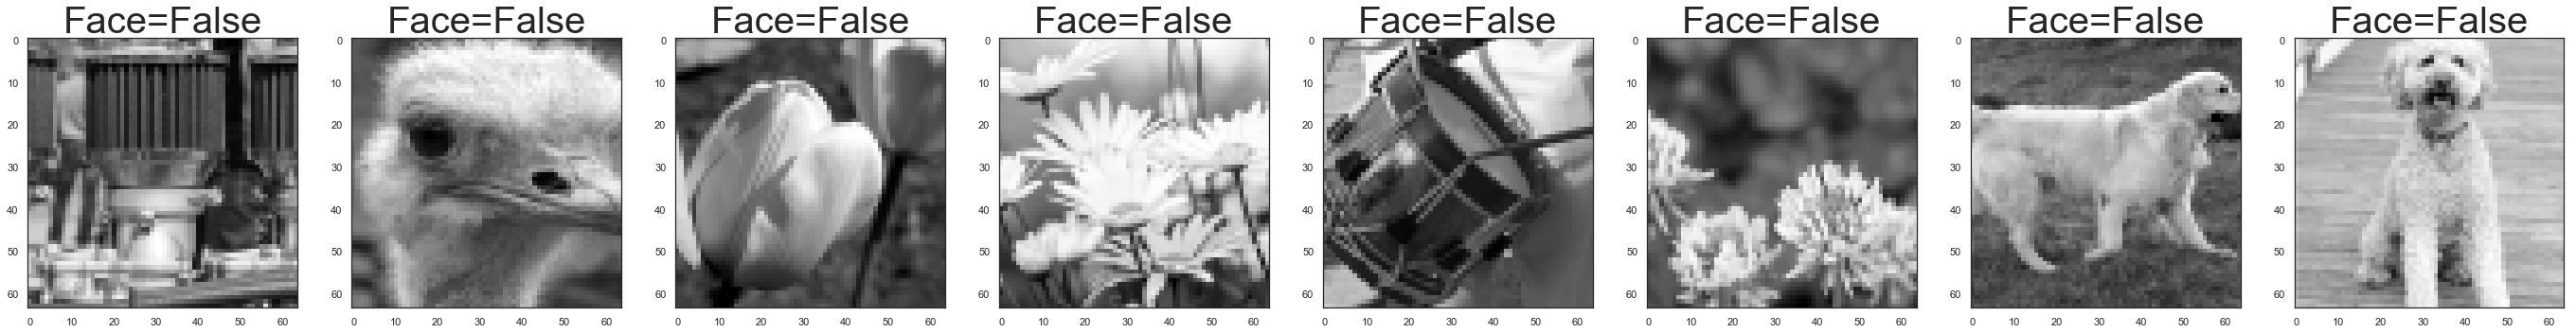

In [16]:
random.seed(256)
imgs_show([(non_face_test[i], "Face={}".format(pca.predict(non_face_test[i]))) for i in random.sample(range(0, len(non_face_test)), 8)], 1, 40)

Accurecy=0.8963855421686747
Precision=0.8739130434782608
Recall=0.9348837209302325
F1 Score=0.9033707865168539


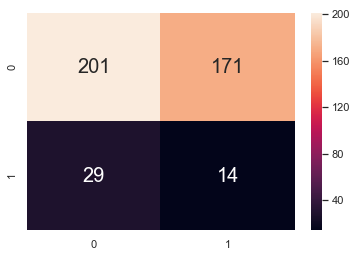

In [17]:
y_true = [len(test), len(non_face_test)]
y_pred = [
    sum([pca.predict(img) for img in test]),
    len(non_face_test) - sum([pca.predict(img) for img in non_face_test])
]

tp = y_pred[0]
tn = y_pred[1]
fp = y_true[1] - y_pred[1]
fn = y_true[0] - y_pred[0]
df_cm = pd.DataFrame([[tp, tn], [fp, fn]] , range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 20})

precision=tp/(tp+fp)
recall=tp/(tp+fn)
print("Accurecy={}".format((tp + tn)/(tp+tn+fp+fn)))
print("Precision={}".format(precision))
print("Recall={}".format(recall))
print("F1 Score={}".format(2*(precision*recall/(precision+recall))))

# Face recognition

For this task another dataset called AT&T Laboratories Cambridge is used. This is done because the each class has the same number of images.

In [18]:
att_faces = read_folder('./att_faces/', '.pgm')
att_faces_train, att_faces_test = train_test_split(att_faces, test_size=.25, random_state=512, shuffle=True)
print("Train set shape: {}. Test set shape: {}".format(len(att_faces_train), len(att_faces_test)))

Train set shape: 300. Test set shape: 100


In [20]:
def find_best_number_of_components(train, test):
    f = IntProgress(min=0, max=len(train)//2, description='Computing:', bar_style='info')
    display(f)
    
    face_recognition_pca = Classifier()
    face_recognition_pca.fit(np.array(train))
    accurecy = []
    for n in range(len(train)//2):
        face_recognition_pca.calculate_weights(n+1)
        face_recognition_pca.calculate_threshold()
        count = 0
        for img in test:
            _, face_in_db = face_recognition_pca.find_closest(img)
            if face_in_db:
                count+=1
        f.value += 1
        accurecy.append(count/len(test))
        
    return accurecy

In [21]:
accurecy = find_best_number_of_components(att_faces_train, att_faces_test)

IntProgress(value=0, bar_style='info', description='Computing:', max=150)

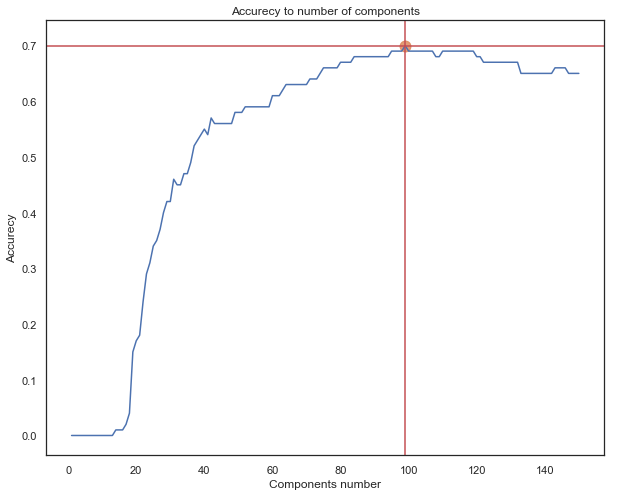

In [22]:
df = pd.DataFrame({
    'Accurecy': accurecy,
    'Components number': [i + 1 for i in range(len(att_faces_train)//2)]
})

best = np.argmax(accurecy)
        
fig, ax = plt.subplots(figsize=(10, 8))
        
sns.set_style("whitegrid")
sns.lineplot(
    ax=ax, 
    y='Accurecy', 
    x='Components number',
    data=df,
).set_title("Accurecy to number of components")
sns.regplot(x=np.array([best+1]), y=np.array([accurecy[best]]), scatter=True, fit_reg=False, marker='o', scatter_kws={"s": 120})
plt.axhline(y=accurecy[best], color='r')
plt.axvline(best+1, color='r')
plt.show()

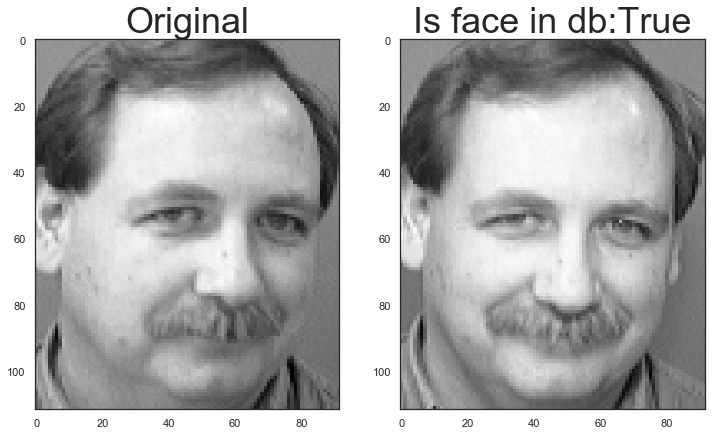

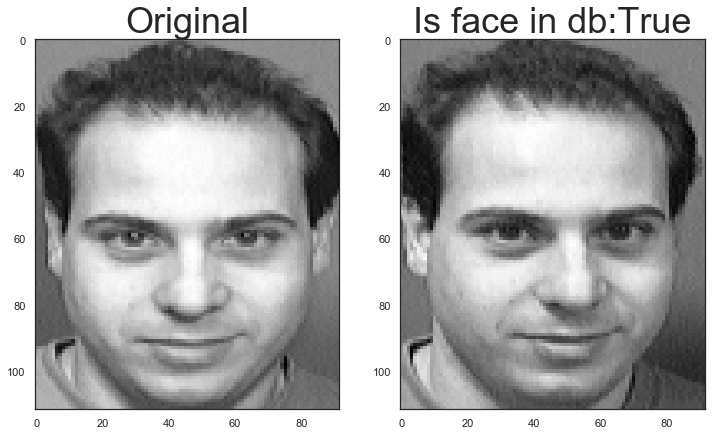

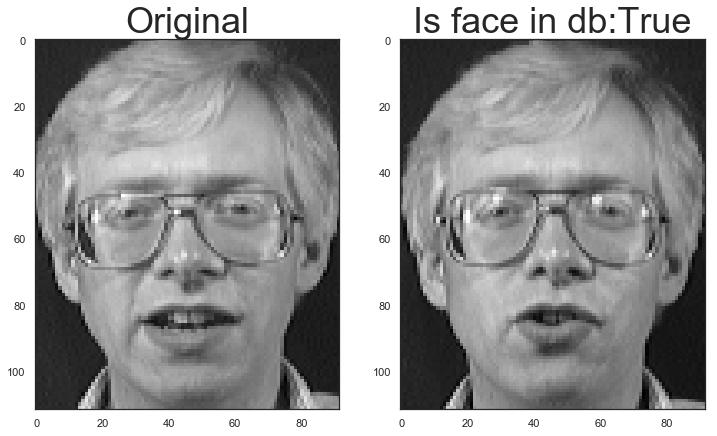

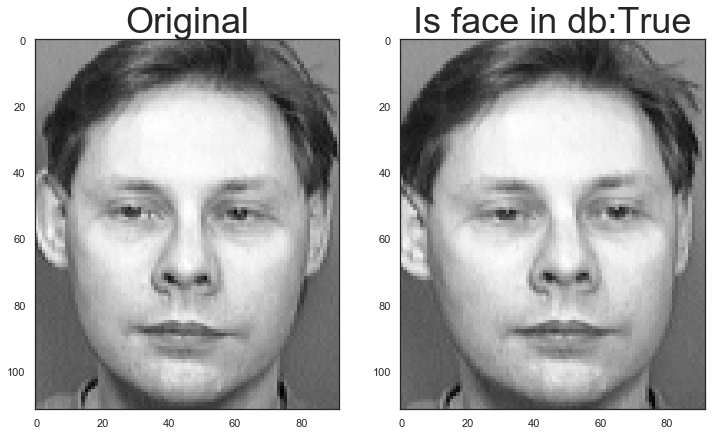

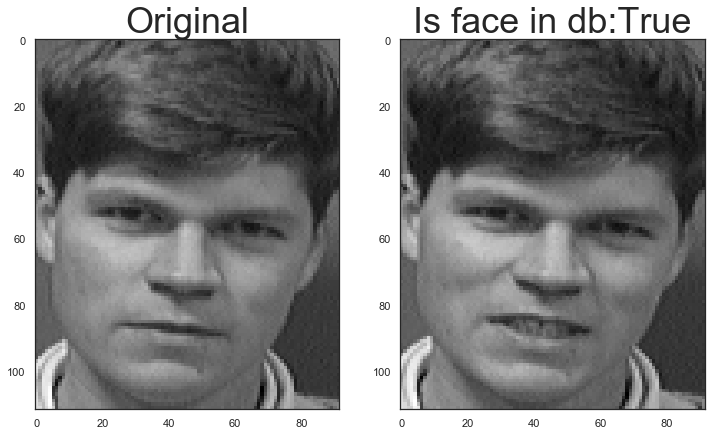

In [23]:
face_recognition_pca = PlotableClassifier()
face_recognition_pca.fit(np.array(att_faces_train))

face_recognition_pca.calculate_weights(best+1)
face_recognition_pca.calculate_threshold()

random.seed(256)
for i in random.sample(range(0, len(att_faces_test)), 5):
    original = att_faces_test[i]
    closest, face_in_db = face_recognition_pca.find_closest(att_faces_test[i])
    imgs_show([(original, "Original"), (closest, "Is face in db:{}".format(face_in_db))], 1)